In [ ]:
# ..... run MN cross-species against Qiu mouse data ..... #

In [2]:
library(Seurat)
library(SingleCellExperiment)
library(MetaNeighbor)
library(dplyr)

In [93]:
# load data
get_seurat_obj <- function(species, currstage1){
    
    sc1 = readRDS(paste0(species, '/', currstage1, '_integrated_cca.rds'))

#     df1 = read.delim(paste0(currstage1, '_Knight-Schrijver_celltypes.csv'), sep = ',')
    df1 = read.delim(paste0(species, '/', currstage1, '_Qiu_SHC_Monocle_clusters.csv'), sep = ',')
    
    ids = match(rownames(sc1@meta.data), df1$barcode)
    
#     sc1$class = df1$class[ids]
#     sc1$celltype = df1$final_celltype[ids]
#     sc1$cluster = df1$cluster[ids]
    
    sc1$stage = currstage1
    sc1$celltype2 = df1$class[ids]
    sc1$celltype = df1$monocle_label[ids]
    sc1$species = species

    sc1 <- sc1[,!is.na(sc1$celltype) & sc1$celltype!='unassigned']
    return(sc1)
}

In [95]:
# load list of orthologs
# om = read.delim('turtle/mouse_turtle_orthologs_biomart.txt', sep = '\t')
# colnames(om) <- c('mouse', 'turtle', 'LCA', 'homology_type', 'orthology_confidence')
om = read.delim('chicken/mouse_chicken_orthologs_biomart.txt', sep = '\t')
colnames(om) <- c('mouse', 'chicken', 'LCA', 'homology_type')

om <- om[om[,1]!='' & om[,2]!='' & om$homology_type=='ortholog_one2one',]
dim(om)
om[1,]

[1] 12287     4

mouse  chicken LCA     homology_type   
6 mt-Nd1 ND1     Amniota ortholog_one2one

In [4]:
# load mouse data
load('Qiu_mouse_E11.5.Rdata')
ls()

[1] "om"   "sce2"

In [10]:
exp2 = counts(sce2)

# add cols
sce2$species = 'mouse'
sce2$celltype = sce2$major_trajectory
sce2$celltype2 = sce2$celltype_update

# get metadata
mtd2 = data.frame(colData(sce2))
mtd2 <- mtd2[,c('species', 'stage', 'celltype', 'celltype2')]

In [94]:
# load individual sample files
stage1 = 'stage32'
sce1 = get_seurat_obj('chicken', stage1)

In [96]:
exp1 = sce1@assays$RNA@counts

# get metadata
cols = c('species', 'stage', 'celltype', 'celltype2')
mtd1 = sce1@meta.data[,cols]

In [97]:
# rename other-species data gene names
rownames(exp1) <- om[match(rownames(exp1), om[,2]),1]
exp1 <- exp1[!is.na(rownames(exp1)),]

In [98]:
# subset to common orthologs
common_genes = intersect(rownames(exp1), rownames(exp2))
length(common_genes)
exp1 <- exp1[common_genes,]
exp2 <- exp2[common_genes,]

[1] 9984

In [99]:
# make SCE object
sce = SingleCellExperiment(list(counts = cbind(exp1, exp2)),
                           colData = DataFrame(rbind(mtd1, mtd2)))
sce$species_stage = paste0(sce$species, '-', sce$stage)
sce

class: SingleCellExperiment 
dim: 9984 255244 
metadata(0):
assays(1): counts
rownames(9984): Spry2 Pcdh20 ... Qprt Trp53
rowData names(0):
colnames(255244): stage32_sample5_AAACCCACAAGGATGC-1
  stage32_sample5_AAACCCACATACTGTG-1 ...
  run_16_PD-12H_S384.TGATCTTCTTGGCGAGCTTA,E11.5,embryo_38,run_16
  run_16_PD-12H_S384.TTCTCATTGTTGCATATAAC,E11.5,embryo_38,run_16
colData names(5): species stage celltype celltype2 species_stage
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [100]:
# only keep common cells
mtd0 = data.frame(colData(sce))
temp = data.frame(mtd0 %>% group_by(celltype) %>% summarise(count = length(unique(species))))
common_celltypes = temp$celltype[temp$count==2]

In [101]:
options(warn = -1)
start.time <- Sys.time()
hvg = variableGenes(sce, exp_labels = sce$species)
length(hvg)

# defaults to top 95% of genes. May need to vary
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

# get top 2k hvgs
if(length(hvg)>2000){
    hvg <- sample(hvg, 2000, replace = F)
}

[1] 1339

Time difference of 7.617642 secs

In [102]:
# MN scores
options(warn = -1)
aurocsall = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$species, 
    cell_type = sce$celltype, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = TRUE)

aurocs1v1 = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$species, 
    cell_type = sce$celltype, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = TRUE)

In [105]:
# plot heatmaps #
ctypes_all = sub('.*\\|', '', rownames(aurocsall))
keep_ids = which(ctypes_all %in% common_celltypes)
aurocsmat = aurocsall[keep_ids,keep_ids]

exps = sub('\\|.*', '', rownames(aurocsmat))
ctypes = sub('.*\\|', '', rownames(aurocsmat))

subs2 = c('Intermediate_neuronal_progenitors', 'Hepatocytes', 'Cardiomyocytes', 'Muscle_cells',  
          'Intestine', 'Lung_and_airway', 'Olfactory_sensory_neurons', 'CNS_neurons', 'Mesoderm',
          'Primitive_erythroid', 'White_blood_cells', 'Definitive_erythroid', 
          'Mast_cells', 'Megakaryocytes', 'B_cells',
          'Neuronal_Cells', 'Endothelium', 'Epithelial_cells', 'Eye_and_other',
          'Neural_crest_PNS_glia', 'Neural_crest_PNS_neurons', 'Neuroectoderm_and_glia')

subcol2 = c('#29c5f6', '#f87cc3', '#d43035', '#e78b00',  
            '#cd7883', '#ff9aba', '#651f7e', '#643b9f', '#088f8f',
            '#dce775', '#574e3c', '#84b023', 
            '#708238', '#358957', '#90ee90',
            '#4900e6', '#fc6c85', '#a94064', '#c154c1',
           '#3a9bdc', '#5579c6', '#1260cc')

reg2 = c('chicken', 'mouse')
regcols2 = c('#8dd7bf', '#e77577')

cols1 = subcol2[match(ctypes, subs2)]
cols2 = regcols2[match(exps, reg2)]

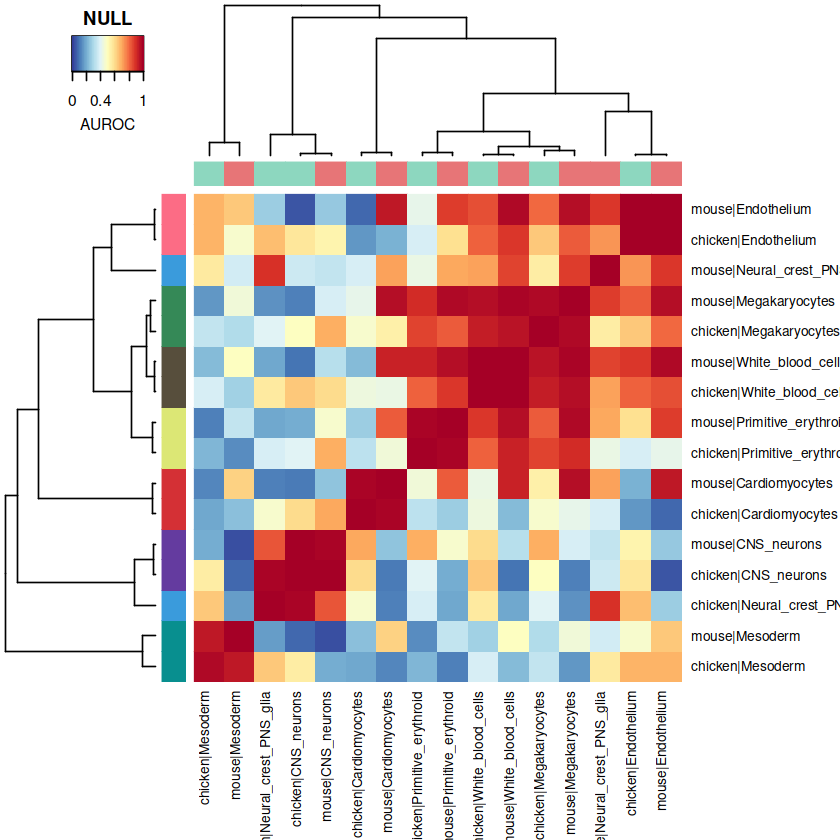

In [106]:
# png(paste0(stages[id], '_', samples[id], '_Mantri_MN.png'), width = 10, height = 10, res = 300, units = 'in')
# pdf('aa-chicken-turtle-mn-all-spe.pdf', width = 10, height = 10)
plotHeatmap(aurocsmat, ColSideColors = cols2, RowSideColors = cols1, margins = c(10,10))
# dev.off()

In [107]:
# save
mn_all = aurocsall[keep_ids,keep_ids]
mn_1v1 = aurocs1v1[keep_ids,keep_ids]
save(mn_all, mn_1v1, file = 'mouse_chicken_MN_scores.Rdata')